In [1]:
%load_ext autoreload
%autoreload 2

from dataset import CustomImageDataset
import torch
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import DataLoader
from torch import nn
from torchvision import datasets, transforms
from torch.nn.init import xavier_uniform
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


val_data = CustomImageDataset(dataset_path="../Datasets/face-emotion", mode="val", transform="grayscale")

val_dataloader = DataLoader(val_data, batch_size=8, shuffle=True)


In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        xavier_uniform(self.conv1.weight)
        self.batch_norm1 = nn.BatchNorm2d(num_features=32)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(num_features=64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.4)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        # Max pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers
        self.linear_shape = 64 * 56 * 56
        self.fc1 = nn.Linear(self.linear_shape, 1024)
        self.fc2 = nn.Linear(1024, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.conv3(x)
        x = self.pool(x)

        x = x.view(-1, self.linear_shape)

        x = self.fc1(x)
        x = self.fc2(x)

        return x


model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("./models/paulinho.pt"))
model.eval()

Using cuda device


C:\Users\pauli\AppData\Local\Temp\ipykernel_2992\466733082.py:16: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  xavier_uniform(self.conv1.weight)


NeuralNetwork(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.4, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.4, inplace=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=200704, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
)

c:\Users\pauli\OneDrive - University of Surrey\work\emotion-recognition\dataset.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(


[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]
[1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0]


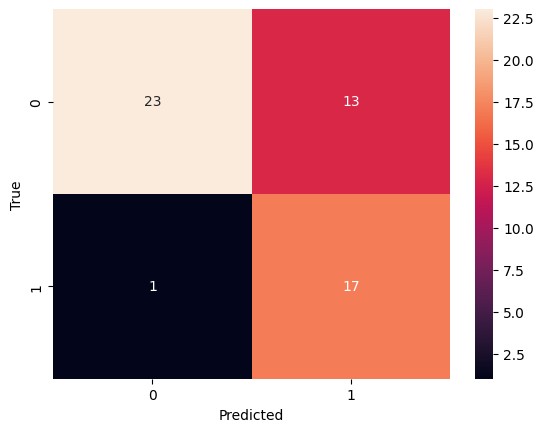

In [3]:


true_labels = []
predictions = []

# Iterate over the dataloader
for inputs, labels in val_dataloader:

    with torch.no_grad():  # No need to track gradients
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
    
    # Append true labels and predictions
    true_labels.extend(labels.argmax(-1).cpu().numpy())
    predictions.extend(predicted.cpu().numpy())
    
print(true_labels)
print(predictions)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plotting the confusion matrix
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Actual class: happy
Predicted class: happy


c:\Users\pauli\OneDrive - University of Surrey\work\emotion-recognition\dataset.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(


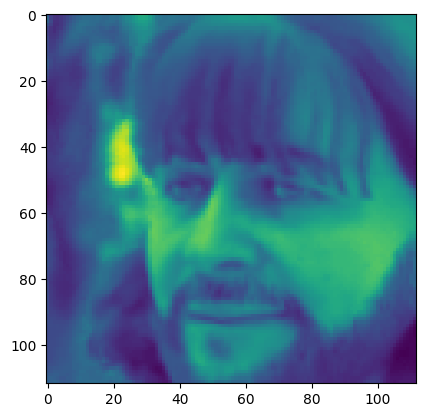

In [4]:




X, y = val_data.__getitem__(16)

X_cpu = X.cpu()
X_cpu = torch.reshape(X_cpu, (112,112,1))

X = X.unsqueeze(0)

logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)

if (y.argmax(-1) == 0):
    print(f"Actual class: happy")
if (y.argmax(-1) == 1):
    print(f"Actual class: sad") 
if (pred_probab.argmax(1)[0] == 0):
    print(f"Predicted class: happy")
if (pred_probab.argmax(1)[0] == 1):
    print(f"Predicted class: sad")

plt.imshow(X_cpu)
plt.show()
